## Imports & Constants

In [1]:
import re
import random
from datetime import datetime
import pandas as pd
import numpy as np
import spacy
import scispacy
import en_core_sci_sm
import en_ner_bc5cdr_md
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [2]:
FILE_NAME = '../data/metadata.csv'
SELECTED_COLUMNS = ['cord_uid', 'title', 'license', 'abstract', 'publish_time', 'authors', 'journal', 'url']

## Read Dataset

In [3]:
df = pd.read_csv(FILE_NAME)
df = df[SELECTED_COLUMNS]

## Size DataFrame

In [4]:
len(df)

52398

## DataFrame glimp

In [5]:
df.head()

,cord_uid,title,license,abstract,publish_time,authors,journal,url
0,xqhn0vbp,Airborne rhinovirus detection and effect of ul...,no-cc,"BACKGROUND: Rhinovirus, the most common cause ...",2003-01-13,"Myatt, Theodore A; Johnston, Sebastian L; Rudn...",BMC Public Health,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...
1,gi6uaa83,Discovering human history from stomach bacteria,no-cc,Recent analyses of human pathogens have reveal...,2003-04-28,"Disotell, Todd R",Genome Biol,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...
2,le0ogx1s,A new recruit for the army of the men of death,no-cc,"The army of the men of death, in John Bunyan's...",2003-06-27,"Petsko, Gregory A",Genome Biol,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...
3,fy4w7xz8,Association of HLA class I with severe acute r...,no-cc,BACKGROUND: The human leukocyte antigen (HLA) ...,2003-09-12,"Lin, Marie; Tseng, Hsiang-Kuang; Trejaut, Jean...",BMC Med Genet,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...
4,0qaoam29,A double epidemic model for the SARS propagation,no-cc,BACKGROUND: An epidemic of a Severe Acute Resp...,2003-09-10,"Ng, Tuen Wai; Turinici, Gabriel; Danchin, Antoine",BMC Infect Dis,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...


In [6]:
df.describe(include='all')

,cord_uid,title,license,abstract,publish_time,authors,journal,url
count,52398,52240,52398,43168,52390,50119,47156,52096
unique,52365,51413,13,42762,6511,47804,6320,52092
top,adygntbe,Infectious disease surveillance update,els-covid,Unknown,2020,"Parry, Jane",Journal of Virology,http://ajph.aphapublications.org/doi/pdf/10.21...
freq,2,26,19995,338,582,32,1750,2


## Remove Duplicate by cord_uid

In [7]:
df = df.drop_duplicates(subset='cord_uid', keep="last").reset_index(drop=True)

## Missing value counts by column

In [8]:
len(df) - df.count()

cord_uid           0
title            158
license            0
abstract        9218
publish_time       8
authors         2279
journal         5239
url              302
dtype: int64

We will work with title and abstract, let's remove when we don't have one of it

In [9]:
df = df.dropna(subset=['abstract', 'title']).reset_index(drop=True)

## Let's try to extract some keys from the text with a focus on cures

https://medium.com/@maheshdmahi/scispacy-for-bio-medical-named-entity-recognition-ner-63ed548f1df0

https://arxiv.org/pdf/1811.05468.pdf

https://allenai.github.io/scispacy/

## Name entity recognision

In [10]:
text = df['abstract'][20003] # example

In [11]:
text

'Diagnostic virus isolation is still frequently used, particularly from respiratory tract secretions. Testing positive virus cultures for all possible viruses is time-consuming, and unexpected or unknown viruses may escape detection. Therefore, a novel random PCR approach was developed that allows sequence-independent amplification of viral nucleic acids from virus isolation-positive cultures. Selectivity for viral sequences is obtained by preferential isolation of nucleic acids that are particle associated and resistant to nucleases. Using primers with a degenerated 3′ end, the isolated nucleic acids are amplified and the randomly amplified PCR products are cloned and sequenced. As proof of the concept, the PAN-PCR approach was applied to supernatants of coxsackievirus B3 and murine adenovirus type 1-infected cells. Enterovirus and adenovirus sequences were obtained, demonstrating that the random PCR approach allows detection of RNA and DNA viruses. As a first application of this PAN-

In [12]:
nlp1 = spacy.load("en_core_sci_sm") 

In [13]:
entities = list(nlp1(text).ents)
entities_type = [e.label_ for e in entities]
entities_name = [e.text for e in entities]

dict(zip(entities_name, entities_type))

{'B': 'ENTITY',
 'DNA': 'ENTITY',
 'DNA preparation': 'ENTITY',
 'DNA viruses': 'ENTITY',
 'Diagnostic virus': 'ENTITY',
 'Enterovirus': 'ENTITY',
 'HSV-1': 'ENTITY',
 'HSV-1 genome': 'ENTITY',
 'HSV-PCR': 'ENTITY',
 'PAN-PCR': 'ENTITY',
 'PCR': 'ENTITY',
 'PCR products': 'ENTITY',
 'Particle-associated': 'ENTITY',
 'RNA': 'ENTITY',
 'Selectivity': 'ENTITY',
 'Testing': 'ENTITY',
 'adenovirus': 'ENTITY',
 'adenovirus sequences': 'ENTITY',
 'amplified': 'ENTITY',
 'applicability': 'ENTITY',
 'associated and': 'ENTITY',
 'chronic fatigue syndrome': 'ENTITY',
 'cloned': 'ENTITY',
 'concept': 'ENTITY',
 'coxsackievirus B2': 'ENTITY',
 'coxsackievirus B3': 'ENTITY',
 'degenerated': 'ENTITY',
 'detection': 'ENTITY',
 'diagnostic': 'ENTITY',
 'enteroviruses': 'ENTITY',
 'herpes simplex virus type 1': 'ENTITY',
 'high antibody': 'ENTITY',
 'identification': 'ENTITY',
 'immunofluorescence': 'ENTITY',
 'infected cells': 'ENTITY',
 'influenza viruses': 'ENTITY',
 'isolate': 'ENTITY',
 'isolated':

### Let's focus on just Disease and Chemical

In [14]:
nlp2 = spacy.load("en_ner_bc5cdr_md")

In [15]:
entities = list(nlp2(text).ents)
entities_type = [e.label_ for e in entities]
entities_name = [e.text for e in entities]

In [16]:
d = dict(zip(entities_name, entities_type))

In [17]:
d

{'Enterovirus': 'DISEASE',
 'coxsackievirus B2': 'CHEMICAL',
 'coxsackievirus B3': 'CHEMICAL',
 'fatigue syndrome': 'DISEASE',
 'herpes simplex': 'DISEASE',
 'nucleic acids': 'CHEMICAL',
 'respiratory tract secretions': 'DISEASE'}

### Apply NER on Titles to extract some info

Really long run (~30min) when we apply it on 'abstract' and not on 'title'

In [18]:
def remove_special_chars(text, remove_digits=False):
    pattern = r'[^a-zA-Z0-9\s]' if not remove_digits else r'[^a-zA-Z\s]'
    return re.sub(pattern, '', text)

In [20]:
entities_list = [list(nlp2(remove_special_chars(e)).ents) for e in df['abstract']]
entities_type_list = [[e.label_ for e in entities]for entities in entities_list ]
entities_name_list = [[e.text for e in entities] for entities in entities_list]

In [21]:
len(entities_name_list)

42998

In [22]:
DISEASES_ERROR = ['sarscoronavirus', 'sarscov2', 'sarscov2 infection', 'covid19', 'ah1n1', 'sars']

In [23]:
temp = [dict(zip(entities_type_list[i], entities_name_list[i])) for i in range(len(entities_name_list))]

diseases = [list(value for key, value in t.items() if key == 'DISEASE' or value.lower() in DISEASES_ERROR) 
            for t in temp]
chemicals = [list(value for key, value in t.items() if key == 'CHEMICAL' and value.lower() not in DISEASES_ERROR) 
             for t in temp]

In [24]:
df['disease_on_abstract'] = diseases
df['chemicals_on_abstract'] = chemicals

In [25]:
df.to_csv('../data/metadata_with_ner_19_04.csv')

## Most commun Chemicals and Diseases

In [27]:
chemical_flat_list = [item.lower() for sublist in df['chemicals_on_abstract'] for item in sublist]

c = Counter(chemical_flat_list)
c.most_common(25)

[('amino acid', 486),
 ('ifn', 363),
 ('nucleic acid', 355),
 ('nucleotide', 351),
 ('tgev', 219),
 ('amino acids', 213),
 ('merscov infection', 180),
 ('oxygen', 175),
 ('cap', 134),
 ('nucleic acids', 121),
 ('ha', 108),
 ('ribavirin', 94),
 ('balbc', 93),
 ('k', 90),
 ('np', 88),
 ('na', 85),
 ('cholesterol', 82),
 ('ncp', 80),
 ('merscov', 74),
 ('e2', 68),
 ('cc', 67),
 ('carbohydrate', 64),
 ('trypsin', 61),
 ('lactate', 56),
 ('corticosteroids', 55)]

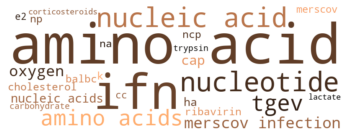

In [28]:
wordcloud = WordCloud(prefer_horizontal=1.0,
                      width=800,
                      height=300,
                      max_font_size=200,
                      max_words=25,
                      colormap="copper",
                      background_color='white').generate_from_frequencies(c)
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
plt.close()

In [29]:
disease_flat_list = [item.lower() for sublist in df['disease_on_abstract'] for item in sublist]

c = Counter(disease_flat_list)
c.most_common(15)

[('infection', 2831),
 ('sars', 1221),
 ('covid19', 1055),
 ('infections', 750),
 ('infectious diseases', 716),
 ('respiratory syndrome', 665),
 ('sarscov2', 584),
 ('infectious disease', 520),
 ('viral infection', 491),
 ('diarrhea', 440),
 ('pneumonia', 432),
 ('death', 396),
 ('viral infections', 394),
 ('mers', 295),
 ('cancer', 275)]

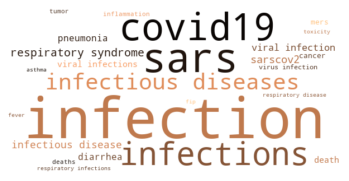

In [30]:
wordcloud = WordCloud(prefer_horizontal=1.0,
                      width=600,
                      height=300,
                      max_font_size=100,
                      max_words=25,
                      colormap="copper",
                      background_color='white').generate_from_frequencies(c)
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
plt.close()